In [32]:
from Annotation_Untils import singular_comment_with_annotation, singular_comment_without_annotation, annotate_comment, auto_label
from DataCleaning_Untils import clean_comment

import pandas as pd
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import BertTokenizer, BertModel
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [33]:
path = os.path.join(os.getcwd(), 'Data', 'Train', 'train.csv') # Adjust the path as needed
df = pd.read_csv(path)
df = df.dropna(subset=['comment_text'])
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos to you for taking it on. Very impressive!,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on my site? When will you be releasing it?,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [34]:
df = df[['id', 'comment_text']]

In [35]:
df.head()

,id,comment_text
0,59848,"This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!"
1,59849,"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"
2,59852,This is such an urgent design problem; kudos to you for taking it on. Very impressive!
3,59855,Is this something I'll be able to install on my site? When will you be releasing it?
4,59856,haha you guys are a bunch of losers.


In [36]:
flag_loader = True # Set to True to load in cleaned csv, else it will clean the data (AGAIN!)

if flag_loader:
    df = pd.read_csv(os.path.join(os.getcwd(), 'Data', 'Train', 'cleaned_train.csv'))
else:
    # Clean the comments
    df['comment_text'] = df['comment_text'].apply(clean_comment)
    # Save the cleaned data
    df.to_csv(os.path.join(os.getcwd(), 'Data', 'Train', 'cleaned_train.csv'), index=False)

In [37]:
df.head()

,comment_text
0,this is so cool its like would you want your mother to read this really great idea well done
1,thank you this would make my life a lot less anxietyinducing keep it up and dont let anyone get in your way
2,this is such an urgent design problem kudos to you for taking it on very impressive
3,is this something ill be able to install on my site when will you be releasing it
4,hata you guns are a bunch of losers


In [38]:
flag_test = True # Set to True to go with sample test data, else it will use the full dataset
if flag_test:
    df = df.sample(5000, random_state=42).reset_index(drop=True)

df = df[df["comment_text"].notnull()]
comments = df["comment_text"].astype(str).tolist()

In [39]:
processed_training_data = annotate_comment(comments)
processed_training_data = pd.DataFrame(processed_training_data)
processed_training_data['label'] = processed_training_data.apply(auto_label, axis=1)
processed_training_data = pd.get_dummies(processed_training_data, columns=['sentiment', 'emotion'])

Annotating comments: 100%|██████████| 4993/4993 [25:30<00:00,  3.26it/s]


In [40]:
processed_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4993 entries, 0 to 4992
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   comment             4993 non-null   object 
 1   hate_score          4993 non-null   float64
 2   toxicity            4993 non-null   float64
 3   obscene             4993 non-null   float64
 4   identity_attack     4993 non-null   float64
 5   insult              4993 non-null   float64
 6   threat              4993 non-null   float64
 7   sexual_explicit     4993 non-null   float64
 8   label               4993 non-null   object 
 9   sentiment_negative  4993 non-null   bool   
 10  sentiment_neutral   4993 non-null   bool   
 11  sentiment_positive  4993 non-null   bool   
 12  emotion_anger       4993 non-null   bool   
 13  emotion_fear        4993 non-null   bool   
 14  emotion_joy         4993 non-null   bool   
 15  emotion_love        4993 non-null   bool   
 16  emotio

In [41]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128, padding='max_length')
    with torch.no_grad():
        outputs = model(**inputs)
    # Use the [CLS] token embedding (pooled representation)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

In [42]:
processed_training_data['bert_embedding'] = processed_training_data['comment'].apply(get_bert_embedding)

In [43]:
scalar_features = processed_training_data[['hate_score', 'toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit', \
                                           'sentiment_negative', 'sentiment_neutral', 'sentiment_positive', \
                                           'emotion_anger', 'emotion_fear', 'emotion_joy', 'emotion_love', 'emotion_sadness', 'emotion_surprise']].values

In [44]:
X = np.hstack((np.vstack(processed_training_data['bert_embedding']), scalar_features))  

In [45]:
le = LabelEncoder()
y = le.fit_transform(processed_training_data['label'])

print("Label Mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

Label Mapping: {'delete': np.int64(0), 'keep': np.int64(1)}


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_train, y_train)

print("Accuracy:", clf.score(X_test, y_test))

Accuracy: 0.8168168168168168


Accuracy: 0.8168168168168168

=== Classification Report ===
              precision    recall  f1-score   support

        keep       0.81      0.83      0.82       499
      delete       0.83      0.80      0.81       500

    accuracy                           0.82       999
   macro avg       0.82      0.82      0.82       999
weighted avg       0.82      0.82      0.82       999



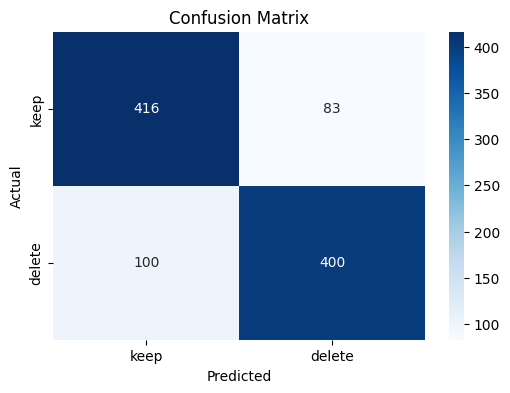

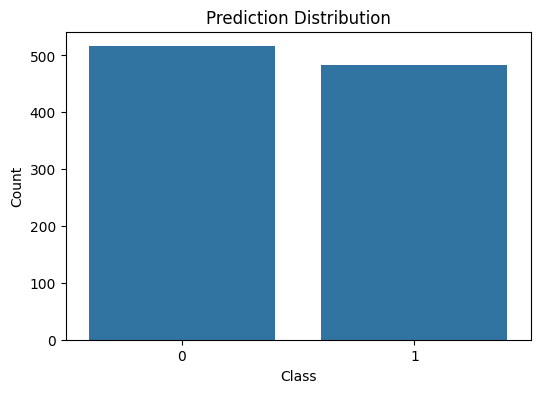

In [47]:
# Predict
y_pred = clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Classification Report
print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=["keep", "delete"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
df_cm = pd.DataFrame(cm, index=["keep", "delete"], columns=["keep", "delete"])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Distribution of Predictions
pred_dist = pd.Series(y_pred).value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=pred_dist.index, y=pred_dist.values)
plt.title("Prediction Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
def predict_comment_with_scalars(comment, tokenizer, bert_model, svm_model, label_encoder):
    # === Step 1: Clean (apply your text cleaner if needed)
    cleaned = clean_comment(comment)  # Optional, if you've defined a cleaner

    # === Step 2: Get BERT embedding
    inputs = tokenizer(cleaned, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    bert_features = outputs.pooler_output.squeeze().numpy()  # shape: (768,)

    # === Step 3: Get scalar features
    sentiment = get_sentiment(comment)
    emotion = get_emotion(comment)
    toxicity = get_toxicity(comment)

    # === Step 4: Encode sentiment & emotion (same mapping as in training)
    sent_map = {'negative': 0, 'neutral': 1, 'positive': 2}
    emo_map = {'joy': 0, 'anger': 1, 'sadness': 2, 'surprise': 3, 'fear': 4, 'love': 5, 'others': 6}
    sentiment_encoded = sent_map.get(sentiment, 1)  # fallback: neutral
    emotion_encoded = emo_map.get(emotion, 6)      # fallback: others

    scalar_vector = [
        sentiment_encoded,
        emotion_encoded,
        toxicity.get('toxicity', 0.0),
        toxicity.get('obscene', 0.0),
        toxicity.get('identity_attack', 0.0),
        toxicity.get('insult', 0.0),
        toxicity.get('threat', 0.0),
        toxicity.get('sexual_explicit', 0.0)
    ]

    # === Step 5: Concatenate and reshape for SVM
    full_features = np.concatenate([bert_features, scalar_vector]).reshape(1, -1)

    # === Step 6: Predict
    prediction = svm_model.predict(full_features)[0]
    label = label_encoder.inverse_transform([prediction])[0]
    return label